In [ ]:
!pip3 install numpy
!pip3 install matplotlib
!pip3 install pandas

!pip3 install opencv-python

!pip3 install torch torchvision torchaudio

!pip3 install tensorflow
!pip3 install keras
!pip3 install tensorflow

!pip3 install gTTS
!pip3 install librosa
# !pip3 install soundfile

In [1]:
from random import random
import time
import os
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# from torch.utils.data import Dataset
# from torchvision.io import read_image
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms
# import torch.nn as nn
# import torch.nn.functional as F

from gtts import gTTS # for text-to-speech
# import soundfile as sf
from IPython.display import Audio
import librosa
import librosa.effects

In [2]:
# Make plots larger (default [6,4] on my machine)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [12, 8]
# print(mpl.rcParams['figure.figsize'])

## Data Pre-Processing

In [3]:
# Data Directory

datadir = "data/samples/"
# datadir = "data/"
# print(os.listdir(datadir + "/samples") == os.listdir(datadir))

In [4]:
# Get images from data directory
num_images = len(os.listdir(datadir))
print(num_images)

1071


In [5]:
img_paths = list()
characters = set()
captcha_length = []

for img_name in os.listdir(datadir):
  if len(img_name.split(".")) > 1:
    img_path = os.path.join(datadir, img_name)
    label, format = img_name.split(".")
    if format == "png":
      img_paths.append(img_path)

captcha_labels_train = list()
for img_name in os.listdir(datadir):
  if len(img_name.split(".")) > 1:
    label, format = img_name.split(".")
    if format == "png":
      captcha_labels_train.append(label)
      captcha_length.append(len(label))
      for ch in label:
        characters.add(ch)

characters = sorted(characters)

In [6]:
jpg_count = 0
for name in img_paths:
  if (".jpg" in name):
    jpg_count += 1
print(jpg_count)

0


In [7]:
img_label_lst = list(zip(img_paths, captcha_labels_train))
img_label_df = pd.DataFrame(img_label_lst, columns=["img_path", "label"])
img_label_df = img_label_df.sample(frac=1.).reset_index(drop=True)
# dataset.head()
len(img_label_df)

1040

### Removing Blur and Sharpening Images

(Optional)

In [8]:
print(img_label_df[img_label_df['label'] == '8n4n8'])
print(img_label_df.iloc[[0]]['img_path'])
testvar1234 = img_label_df['img_path'].values[0] # (img_label_df.iloc[[0]])['img_path']
print(testvar1234)
print(type(testvar1234))

                   img_path  label
305  data/samples/8n4n8.png  8n4n8
0    data/samples/fg38b.png
Name: img_path, dtype: object
data/samples/fg38b.png
<class 'str'>


##### Original images for comparison

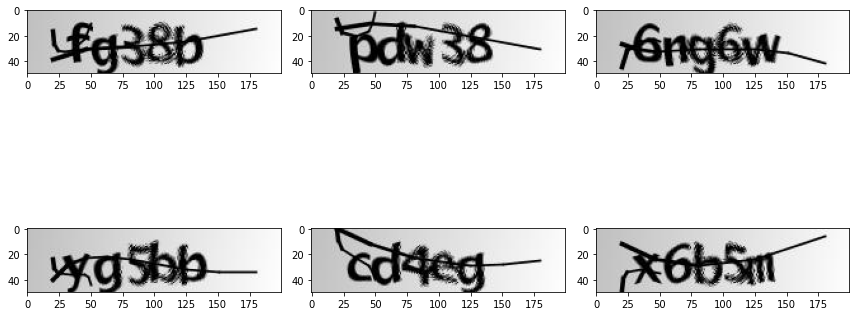

In [9]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols)

row = 0
for img_idx in range(0, 6, 1):
    # print(img_paths[img_index].shape)
    img = cv2.imread(img_label_df['img_path'].values[img_idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img_idx % 3 == 0 and img_idx != 0:
        row += 1
    axes[row, img_idx % num_cols].imshow(img)
    # axes[row, img_index % num_cols].set_title(captcha_labels_train[img_index])

fig.tight_layout()
plt.show()

##### Sharpened, Denoised Images

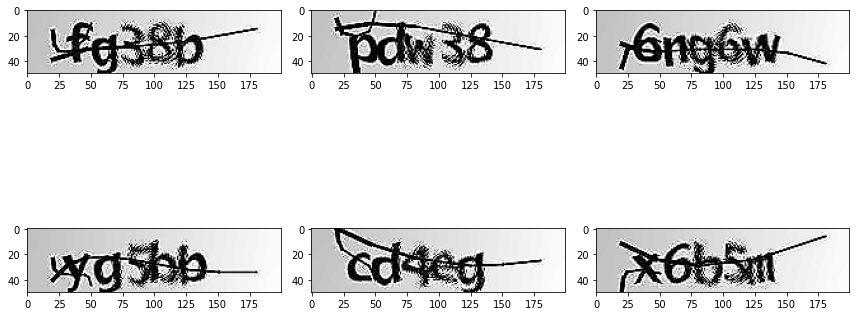

In [10]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols)

row = 0
for img_idx in range(0, 6, 1):
    img = cv2.imread(img_label_df['img_path'].values[img_idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

    sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    sharpened_image = cv2.filter2D(img, -1, sharpen_kernel)
    sharpened_image = cv2.fastNlMeansDenoisingColored(sharpened_image,None,10,10,7,21)

    if img_idx % 3 == 0 and img_idx != 0:
        row += 1
    axes[row, img_idx % num_cols].imshow(sharpened_image)
    # axes[row, img_idx % num_cols].set_title(captcha_labels_train[img_idx])

fig.tight_layout()
plt.show()

The sharpening filter sharpens the edges of characters like '2', which were clear solid characters with soft edges in the sample.
However, it also accentuates the choppy edges in our captcha images. We are unable to remove this with the denoising filter since OpenCV sees it as relevant data, not noise.

Other sharpening filters seem to do the same.

So we will not use sharpening. However, the code is here in case we ever need to run the program on a different dataset

## CRNN Model

In [11]:
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

# Split the dataset into training and validation sets
training_data, validation_data = train_test_split(img_label_df, test_size=0.1, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))



# Map text to numeric labels 
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# Map numeric labels to text
labels_to_char = {val:key for key, val in char_to_labels.items()}



# Sanity check for corrupted images
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True



# Store arrays in memory as it's not a muvh big dataset
def generate_arrays(df, resize=True, img_height=50, img_width=200):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # Add only if it is a valid captcha
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)



# Build training data
training_data, training_labels = generate_arrays(df=training_data)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)

# Build validation data
validation_data, validation_labels = generate_arrays(df=validation_data)
print("Number of validation images: ", validation_data.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of training samples:  936
Number of validation samples:  104
Number of training images:  (936, 50, 200)
Number of training labels:  (936,)
Number of validation images:  (104, 50, 200)
Number of validation labels:  (104,)


In [12]:
class DataGenerator(keras.utils.Sequence):
    """Generates batches from a given dataset.
    
    Args:
        data: training or validation data
        labels: corresponding labels
        char_map: dictionary mapping char to labels
        batch_size: size of a single batch
        img_width: width of the resized
        img_height: height of the resized
        downsample_factor: by what factor did the CNN downsample the images
        max_length: maximum length of any captcha
        shuffle: whether to shuffle data or not after each epoch
    Returns:
        batch_inputs: a dictionary containing batch inputs 
        batch_labels: a batch of corresponding labels 
    """
    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=200,
                 img_height=50,
                 downsample_factor=4,
                 max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
        
        # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the captcha is valid
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [13]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width=200
img_height=50 

# Factor  by which the image is going to be downsampled
# by the convolutional blocks
downsample_factor=4

# Maximum length of any captcha in the data
max_length=5

# Get a generator object for the training data
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Get a generator object for the validation data 
valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

In [14]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss



def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # First conv block
    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    # Second conv block
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Optimizer
    '''
    Note:
        Using the legacy Optimizer since the current optimizer runs slow on M1. TensorFlow throws the following warnings:
            WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.SGD` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.SGD`.
            WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.SGD`.
    '''
    sgd = keras.optimizers.legacy.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    
    # Compile the model and return 
    model.compile(optimizer=sgd)
    return model

In [15]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_data (InputLayer)     [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['input_data[0][0]']          
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

In [16]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Train the model
history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    epochs=50,
                    callbacks=[es])

Epoch 1/50
59/59 [==============================] - 8s 91ms/step - loss: 23.6333 - val_loss: 16.4478
Epoch 2/50
59/59 [==============================] - 5s 90ms/step - loss: 16.3361 - val_loss: 16.2664
Epoch 3/50
59/59 [==============================] - 6s 94ms/step - loss: 16.2167 - val_loss: 16.3490
Epoch 4/50
59/59 [==============================] - 6s 94ms/step - loss: 16.0782 - val_loss: 16.1389
Epoch 5/50
59/59 [==============================] - 5s 85ms/step - loss: 16.0472 - val_loss: 16.3260
Epoch 6/50
59/59 [==============================] - 5s 85ms/step - loss: 16.0229 - val_loss: 16.0766
Epoch 7/50
59/59 [==============================] - 5s 85ms/step - loss: 16.0073 - val_loss: 16.0526
Epoch 8/50
59/59 [==============================] - 5s 86ms/step - loss: 15.9916 - val_loss: 16.0542
Epoch 9/50
59/59 [==============================] - 5s 87ms/step - loss: 15.9888 - val_loss: 16.0246
Epoch 10/50
59/59 [==============================] - 5s 85ms/step - loss: 15.9814 - val_los

In [17]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

In [18]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

In [19]:
#  Let's check results on some validation sample
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']

    # # print(X_data[1].shape)
    # plt.imshow(X_data[1], cmap='gray')
    # plt.show()
    # # sample_to_test = X_data[0]
    # print(X_data[1].shape)
    # # print(X_data[1])

    # preds = prediction_model.predict(np.reshape(X_data[1], (1, 200, 50, 1)))
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    # print(preds)
    print(pred_texts)
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

1/1 [==============================] - 1s 782ms/step
['gxxpf', '6b46g', 'yd3m3', 'b26nd', 'm2nf4', 'n4xx5', 'm3588', 'b43nw', 'men4f', 'mye68', 'pgmn2', '6g45w', 'fcmem', 'ydd3g', '2n3cf', '7wyp4']
Ground truth: gxxpf 	 Predicted: gxxpf
Ground truth: 6b46g 	 Predicted: 6b46g
Ground truth: yd3m3 	 Predicted: yd3m3
Ground truth: b26nd 	 Predicted: b26nd
Ground truth: m2nf4 	 Predicted: m2nf4
Ground truth: n4xx5 	 Predicted: n4xx5
Ground truth: m3588 	 Predicted: m3588
Ground truth: b43nw 	 Predicted: b43nw
Ground truth: men4f 	 Predicted: men4f
Ground truth: mye68 	 Predicted: mye68
Ground truth: pgmn2 	 Predicted: pgmn2
Ground truth: 6g45w 	 Predicted: 6g45w
Ground truth: fcmem 	 Predicted: fcmem
Ground truth: ydd3g 	 Predicted: ydd3g
Ground truth: 3n3cf 	 Predicted: 2n3cf
Ground truth: 7wyp4 	 Predicted: 7wyp4


In [198]:
# ['43p5d', '5yxgp', 'ny8np', '7w67m', 'nngxc', 'neecd', '42dw4', 'wmpmp', 'e2mg2', '57gnx', 'pgwnp', 'cdfen', 'mddgb', 'p2ym2', 'd22y5', 'x8xnp']
from PIL import Image as im

test_img = cv2.imread(datadir + '57gnx.png')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY) 
test_img = test_img.T
# plt.imshow(test_img, cmap = "gray")
# plt.show()
test_img = np.divide(test_img, 255)
test_img = np.expand_dims(test_img, axis=-1)
print(test_img.shape)
# print(test_img)

test_preds = prediction_model.predict(np.reshape(test_img, (1, 200, 50, 1)))
test_pred_texts = decode_batch_predictions(test_preds)
print(test_pred_texts)

(200, 50, 1)
1/1 [==============================] - 0s 28ms/step
['57gnx']


In [ ]:
def detectCaptchaText(path):
    captcha_img = cv2.imread(path)
    captcha_img = cv2.cvtColor(captcha_img, cv2.COLOR_BGR2GRAY) # convert to grayscale to reduce channels from 3 to 1
    captcha_img = captcha_img.T # transpose since we need to pass in (1, 200, 50, 1) to model. This step gets us to (200, 50)
    captcha_img = np.divide(captcha_img, 255) # need 0...255 int values scaled to 0...1 float values
    captcha_img = np.expand_dims(captcha_img, axis=-1) # shape (200, 50) --> (200, 50, 1)

    prediction = prediction_model.predict(np.reshape(captcha_img, (1, 200, 50, 1)))
    prediction_text = decode_batch_predictions(prediction)
    
    return prediction_text

## Text-to-Speech

### Hugging Face Version (Not Using)

In [ ]:
# from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
# from datasets import load_dataset
# import torch
# import soundfile as sf

# processor = SpeechT5Processor.from_pretrained('microsoft/speecht5_tts')
# model = SpeechT5ForTextToSpeech.from_pretrained('microsoft/speecht5_tts')
# vocoder = SpeechT5HifiGan.from_pretrained('microsoft/speecht5_hifigan')

# # inputs = processor(text="Work you stupid piece of crap", return_tensors="pt")
# inputs = processor(text="C.", return_tensors="pt")

# embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
# speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

# speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

# from IPython.display import Audio

# Audio(speech, rate=12000)
# # sf.write("testAudio.wav", speech.numpy())

### GTTS Version

In [ ]:
def label2cleanSpeech(captcha_label:str, out_filename:str="captchaAudioClean.wav", language:str='en'):
    '''
    Input:
        captcha_label: string to convert to audio
        out_filename : file (with path) to save audio (.wav) file to
                     : "captchaAudioClean.wav" by default
        language     : language of text/audio
                     : "en" for English by default
    Returns:
        speech_obj   : gTTS audio object
    '''
    txt = ""
    for character in captcha_label:
        txt += character + "/"
    speech_obj = gTTS(text=txt, lang=language, slow=True) # slow=True for speech to be slow
    speech_obj.save(out_filename)

    return speech_obj


def cleanSpeech2captchaAudio(in_filename:str="captchaAudioClean.wav", out_filename:str="captchaAudioFinal.wav"):
    '''
    Input:
        in_filename  : file (with path: .wav or .mp3) to add noise to
                     : "captchaAudioClean.wav" by default
        out_filename : file (with path) to save final noisy captcha audio (.wav) file to
                     : "captchaAudioFinal.wav" by default
    Returns:
        Audio with pitch shift, noise, and stretch applied
    '''

    original_audio, sr = librosa.load(in_filename, sr=None)

    # Pitch shift
    pitch_shifted_audio = librosa.effects.pitch_shift(original_audio, sr=sr, n_steps=1.0)

    # Add Wald (inverse Gaussian) noise
    noise_audio = pitch_shifted_audio.copy()
    noise_amp = 0.005*np.random.wald(30,2)*np.amax(noise_audio)
    noise_audio = noise_audio.astype('float64') + noise_amp * np.random.normal(size=noise_audio.shape[0])

    # Stretch Audio
    input_length = len(noise_audio)
    stretch_audio = noise_audio.copy()
    stretch_audio = librosa.effects.time_stretch(stretch_audio.astype('float'), rate=1.1)
    if len(stretch_audio) > input_length:
        stretch_audio = stretch_audio[:input_length]
    else:
        stretch_audio = np.pad(stretch_audio, (0, max(0, input_length - len(stretch_audio))), "constant")

    # Audio at 80% of sampling rate
    final_audio = Audio(stretch_audio, rate=0.8*sr)
    # sf.write(out_filename, data=stretch_audio, samplerate=int(sr*0.8), subtype='PCM_24')
    with open(out_filename, 'wb') as f:
        f.write(final_audio.data)
    return final_audio

In [ ]:
label2cleanSpeech("CN8p4")
cleanSpeech2captchaAudio()

## Command Line Interface

In [ ]:
import cmd

class captcha2audioCLI(cmd.Cmd):
    prompt = '>> '
    intro = '''>> Welcome to our CAPTCH to Audio Convertor.\n   Please a full path to the captcha image. Type "help" for available commands.\n'''

    # Help
    def do_help(self, line):
        print(">> Please enter a pathname.\n   Example: /Users/user/Downloads/filename.png")
        print('''   Other commands:\n     - "q" or "quit" to exit''')
    
    # Read CAPTCHA image
    def do_image(self, line):
        while True:
            path = input("Please enter captcha image (full path): ")
            if path in ('quit', 'q', 'exit'):
                break
            try:
                img = cv2.imread(path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
                break
            except:
                print("File does not exist. Please enter a valid path.")
    
    # Post command hook: empty line for better readability
    def postcmd(self, stop, line):
        print()
        return stop
    
    # Quit
    def do_quit(self, line):
        return True
    def do_q(self, line):
        return True
    def do_exit(self, line):
        return True

if __name__ == '__main__':
    captcha2audioCLI().cmdloop()